# Time Series Forecasting in Python:

# Project 1: Objective:

* Combine, clean, and prepare the energy and temperature datasets for exploration and modeling. We will use the combined and cleaned datasets to make the exploration and modeling an easier task in the upcoming sections.

## Data Description:
* hr_temp_20170201-20200131_subset.csv – This is a dataset containing hourly (variable DATE) temperature data (variable HourlyDryBulbTemperature) at a weather station near the area you are forecasting energy for.

* hrl_load_metered - 20170201-20200131.csv – This is a dataset containing hourly (variable datetime_beginning_ept) megawatt usage data (variable mw) for the area in Pennsylvania centered around Duquesne. We are using only three years of data because we want to make sure that we look at recent energy patterns that are still applicable to our current customers.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/milestone1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/milestone1/hrl_load_metered - 20170201-20200131.csv
/kaggle/input/milestone1/hr_temp_20170201-20200131_subset.csv
/kaggle/input/milestone1/hr_temp_20200201-20200229_subset.csv


## 1.0 Load Data:
* First, let's make sure to import date related values with 'datetime64' data type for easy manipulation.

In [3]:
meter = pd.read_csv('/kaggle/input/milestone1/hrl_load_metered - 20170201-20200131.csv')#, parse_dates=['datetime_beginning_utc', 'datetime_beginning_ept'])
weather = pd.read_csv('/kaggle/input/milestone1/hr_temp_20170201-20200131_subset.csv', parse_dates=['DATE'])
weather1 = pd.read_csv('/kaggle/input/milestone1/hr_temp_20200201-20200229_subset.csv', parse_dates=['DATE'])

In [4]:
for column in ['datetime_beginning_utc', 'datetime_beginning_ept']:
    meter[column] = pd.to_datetime(meter[column])

weather = weather.sort_values('DATE')
meter = meter.sort_values('datetime_beginning_ept')
print(f'weather: {weather.shape}')
print(f'meter: {meter.shape}')

weather: (26280, 5)
meter: (26280, 8)


In [5]:
weather.dtypes

STATION                              int64
DATE                        datetime64[ns]
REPORT_TYPE                         object
SOURCE                               int64
HourlyDryBulbTemperature           float64
dtype: object

In [6]:
meter.dtypes

datetime_beginning_utc    datetime64[ns]
datetime_beginning_ept    datetime64[ns]
nerc_region                       object
mkt_region                        object
zone                              object
load_area                         object
mw                               float64
is_verified                         bool
dtype: object

## 2.0 Preprocessing:

### 2.1 Drop/Rename columns:
* Let's drop unnecessary columns and rename some columns for simplicity.

In [7]:
#weather
weather = weather.drop(columns=['STATION','REPORT_TYPE','SOURCE'])

In [8]:
#meter
meter = meter.rename(columns={'datetime_beginning_ept':'DATE'})
meter = meter.drop(columns=['datetime_beginning_utc','nerc_region','mkt_region','zone','load_area','is_verified'])
meter.head()

,DATE,mw
0,2017-02-01 00:00:00,1419.881
1,2017-02-01 01:00:00,1379.505
2,2017-02-01 02:00:00,1366.106
3,2017-02-01 03:00:00,1364.453
4,2017-02-01 04:00:00,1391.265


### 2.2 Index DateTime / Merge DataFrames:
* Let's create extract information (year, month, hour, day, day_of_week) from 'DATE'column.
* Then, we will create new columns for it.
* Fianlly, we will make these columns as index for each dataframe.
* This makes combining our two dataframes (energy & weather) easier using common index.

In [9]:
meter['day_of_week'] = meter.DATE.dt.dayofweek
meter['hour'] = meter.DATE.dt.hour
meter['day'] = meter.DATE.dt.day
meter['month'] = meter.DATE.dt.month
meter['year'] = meter.DATE.dt.year
meter.head(3)

,DATE,mw,day_of_week,hour,day,month,year
0,2017-02-01 00:00:00,1419.881,2,0,1,2,2017
1,2017-02-01 01:00:00,1379.505,2,1,1,2,2017
2,2017-02-01 02:00:00,1366.106,2,2,1,2,2017


In [10]:
weather['day_of_week'] = weather.DATE.dt.dayofweek
weather['hour'] = weather.DATE.dt.hour
weather['day'] = weather.DATE.dt.day
weather['month'] = weather.DATE.dt.month
weather['year'] = weather.DATE.dt.year
weather.head(3)

,DATE,HourlyDryBulbTemperature,day_of_week,hour,day,month,year
0,2017-02-01 00:53:00,37.0,2,0,1,2,2017
1,2017-02-01 01:53:00,37.0,2,1,1,2,2017
2,2017-02-01 02:53:00,36.0,2,2,1,2,2017


In [11]:
weather0 = weather.set_index(['year','month','day','hour','day_of_week'])
meter0 = meter.set_index(['year','month','day','hour','day_of_week'])

weather0 = weather0.drop(columns=['DATE'])
meter0 = meter0.drop(columns=['DATE'])
df = weather0.join(meter0, how='outer')
df = df.rename(columns={'HourlyDryBulbTemperature':'temp'})
df

temp        mw
year month day hour day_of_week                
2017 2     1   0    2            37.0  1419.881
               1    2            37.0  1379.505
               2    2            36.0  1366.106
               3    2            36.0  1364.453
               4    2            36.0  1391.265
...                               ...       ...
2020 1     31  19   4            34.0  1618.484
               20   4            33.0  1580.925
               21   4            33.0  1545.354
               22   4            33.0  1478.832
               23   4            34.0  1405.188

[26283 rows x 2 columns]

### 2.3 Identify Missing Data:
* Not all of the temperature data is recorded, as the stations would occasionally not report.
* So, we will fill in these missing values using linear interpolation.
* Let's look at what data we are mssing.

In [12]:
df.isna().sum()

temp    37
mw       3
dtype: int64

In [13]:
#missing mw values (Mar 12 2017, Mar 11 2018, Mar 10 2019)
# Sunday of 3rd week of March may be the yearly maintenance downtime for energy meter
missing_mw = df[df['mw'].isna()==True]
missing_mw

,,,,,temp,mw
year,month,day,hour,day_of_week,,
2017,3,12,2,6,17.0,NaN
2018,3,11,2,6,23.0,NaN
2019,3,10,2,6,46.0,NaN


In [14]:
# missing temp values (Oct 25 2018, Dec 25 2018, May 26 2019)
# weather temp sensor doesn't exibit any particular yearly maintenance downtime.
# we will fill this temp values with interpolation
missing_temp = df[df['temp'].isna()==True]
missing_temp

temp        mw
year month day hour day_of_week                
2018 10    25  12   3             NaN  1581.431
     12    25  2    1             NaN  1269.577
               3    1             NaN  1263.540
               4    1             NaN  1271.892
               5    1             NaN  1304.021
               6    1             NaN  1340.344
               7    1             NaN  1380.992
               8    1             NaN  1395.445
               9    1             NaN  1422.708
               10   1             NaN  1438.822
               11   1             NaN  1413.274
               12   1             NaN  1394.176
               13   1             NaN  1375.023
               14   1             NaN  1354.344
               15   1             NaN  1348.573
               16   1             NaN  1379.544
               17   1             NaN  1455.665
               18   1             NaN  1462.390
               19   1             NaN  1462.030
               20   1             NaN  1461.466
               21   1             NaN  1448.051
               22   1             NaN  1406.473
               23   1             NaN  1345.258
           26  0    2             NaN  1301.272
               1    2             NaN  1267.715
               2    2             NaN  1264.119
               3    2             NaN  1259.701
               4    2             NaN  1279.052
               5    2             NaN  1332.444
               8    2             NaN  1526.808
               9    2             NaN  1558.543
               10   2             NaN  1564.532
               11   2             NaN  1543.588
2019 5     26  1    6             NaN  1250.662
               2    6             NaN  1216.115
               3    6             NaN  1174.187
               7    6             NaN  1223.292

### 2.4 Treat Missing Data:
* we are missing:
    * 37 temperature data [temp (unit: degree F)]
    * 3 energy consumption data [mw (unit: MWh)]
* Let's use linear interpolation to fill in the gaps with forward direction.

In [15]:
df['temp'] = df['temp'].interpolate(method='linear', limit_direction = 'forward')
df['mw'] = df['mw'].interpolate(method='linear', limit_direction = 'forward')
df.isnull().sum()

temp    0
mw      0
dtype: int64

### 2.5 Re-index with Date:
* we will desolve multi-index (year, month, day, hour)
* Then, we will create a new index, 'date', which will combine all these values.

In [16]:
df = df.reset_index()
df.head(3)

,year,month,day,hour,day_of_week,temp,mw
0,2017,2,1,0,2,37.0,1419.881
1,2017,2,1,1,2,37.0,1379.505
2,2017,2,1,2,2,36.0,1366.106


In [17]:
df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hour=df.hour))
print(df.dtypes)
df.head(3)

year                    int64
month                   int64
day                     int64
hour                    int64
day_of_week             int64
temp                  float64
mw                    float64
date           datetime64[ns]
dtype: object


,year,month,day,hour,day_of_week,temp,mw,date
0,2017,2,1,0,2,37.0,1419.881,2017-02-01 00:00:00
1,2017,2,1,1,2,37.0,1379.505,2017-02-01 01:00:00
2,2017,2,1,2,2,36.0,1366.106,2017-02-01 02:00:00


In [18]:
df = df.set_index('date')
df = df.rename(columns={'day_of_week':'weekday'})
df.head(3)

,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-01 00:00:00,2017,2,1,0,2,37.0,1419.881
2017-02-01 01:00:00,2017,2,1,1,2,37.0,1379.505
2017-02-01 02:00:00,2017,2,1,2,2,36.0,1366.106


### 2.6 Train/Test Split:
* train = from 2017-02-01 to 2019-12-31
* test = from 2020-01-01 to 2020-01-31

In [19]:
train = df[df.index.to_series().between('2017-01-01 00:00:00','2019-12-31 23:59:59') == True]
test = df[df.index.to_series().between('2020-01-01 00:00:00','2020-12-31 23:39:59') == True]

In [20]:
train

,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-01 00:00:00,2017,2,1,0,2,37.0,1419.881
2017-02-01 01:00:00,2017,2,1,1,2,37.0,1379.505
2017-02-01 02:00:00,2017,2,1,2,2,36.0,1366.106
2017-02-01 03:00:00,2017,2,1,3,2,36.0,1364.453
2017-02-01 04:00:00,2017,2,1,4,2,36.0,1391.265
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,19,1,32.0,1606.134
2019-12-31 20:00:00,2019,12,31,20,1,32.0,1565.014
2019-12-31 21:00:00,2019,12,31,21,1,32.0,1515.905


In [21]:
test

,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2020-01-01 00:00:00,2020,1,1,0,2,31.0,1363.428
2020-01-01 01:00:00,2020,1,1,1,2,29.0,1335.975
2020-01-01 02:00:00,2020,1,1,2,2,30.0,1296.817
2020-01-01 03:00:00,2020,1,1,3,2,30.0,1288.403
2020-01-01 04:00:00,2020,1,1,4,2,31.0,1292.263
...,...,...,...,...,...,...,...
2020-01-31 19:00:00,2020,1,31,19,4,34.0,1618.484
2020-01-31 20:00:00,2020,1,31,20,4,33.0,1580.925
2020-01-31 21:00:00,2020,1,31,21,4,33.0,1545.354


In [22]:
# let's confirm that we didn't miss any rows when splitting dataset to train/test
print(f'df: {df.shape[0]}')
print(f'train: {train.shape[0]}')
print(f'test: {test.shape[0]}')
print(f'train+test = df: {train.shape[0]+test.shape[0]} = {df.shape[0]}')

df: 26283
train: 25539
test: 744
train+test = df: 26283 = 26283


## Project 1 Remarks:
* Train (25539)/Test(744) split is successfully completed with no data loss.
* Now, we are ready to submit this assignment.

# Project 2 Objective: 
* Visualize the energy data we are going to model and explore the relationship between the energy data and corresponding temperature data. We will use the takeaways from these explorations to build our first model in the next section.

### Workflow:
* Plot the training energy data over time.
* It is good to look at overall patterns. 
* What generic overall patterns do you notice around the seasons of the year?

### 1.0 Overall Patterns
Let's plot the overall pattern relationship by looking at the temperature and energy consumption.

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

[Text(0.5, 1.0, 'Temperature vs Energy Consumption'),
 Text(0, 0.5, '[MWh]'),
 Text(0.5, 0, '[degree F]')]

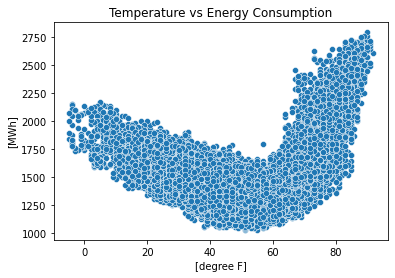

In [24]:
ax = sns.scatterplot(data=train, x='temp', y='mw')
ax.set(title='Temperature vs Energy Consumption', ylabel='[MWh]', xlabel='[degree F]')
#fig.show()

We can see that temp & mw have negative linear relationship below around 60F, and positive linear relationship above around 60F.

Now, let's looks at the trends of temperature and energy consumption over time to see how this relationship changes throughout the year.

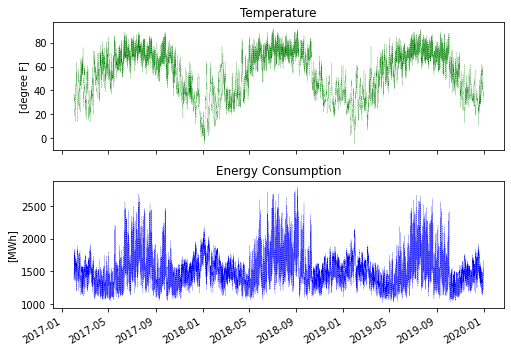

In [25]:
fig, ax = plt.subplots(2,1, figsize=(7.2,5),sharex=True)
ax[0].plot(train.index, train.temp, 'g-.', label='temp', linewidth=.2)
ax[1].plot(train.index, train.mw, 'b-.', label ='mw', linewidth=.2 )
fig.autofmt_xdate()
#ax[0].legend()
#ax[1].legend()
ax[0].set(title='Temperature', ylabel= '[degree F]')
ax[1].set(title='Energy Consumption', ylabel='[MWh]')
plt.tight_layout()

We can see the seasonal behaviour. Each year, temperature goes up during the summer and goes down during winter. Energy consumption is also cyclical. During the summer, increase of temperature correlates with increase in energy consumption. However, increase in temperature during Winter correlates with decrease in energy consumption. Let's look at monthly patterns to identify positive/negative relationship turning point between temperature and energy consumption.

### 1.1 Monthly Patterns

Across entire 2017-2019, let's look at temperature & energy consumption at each hour in each month.

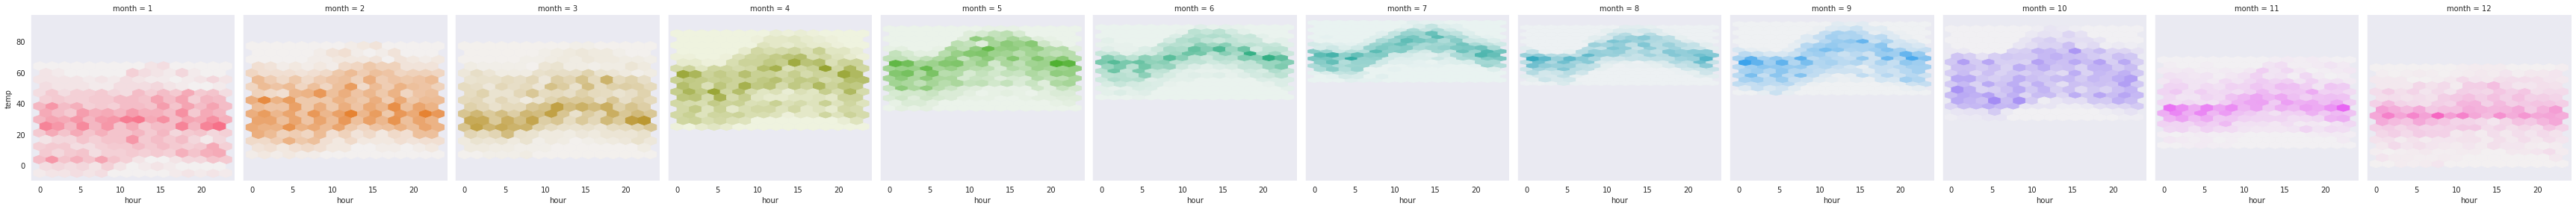

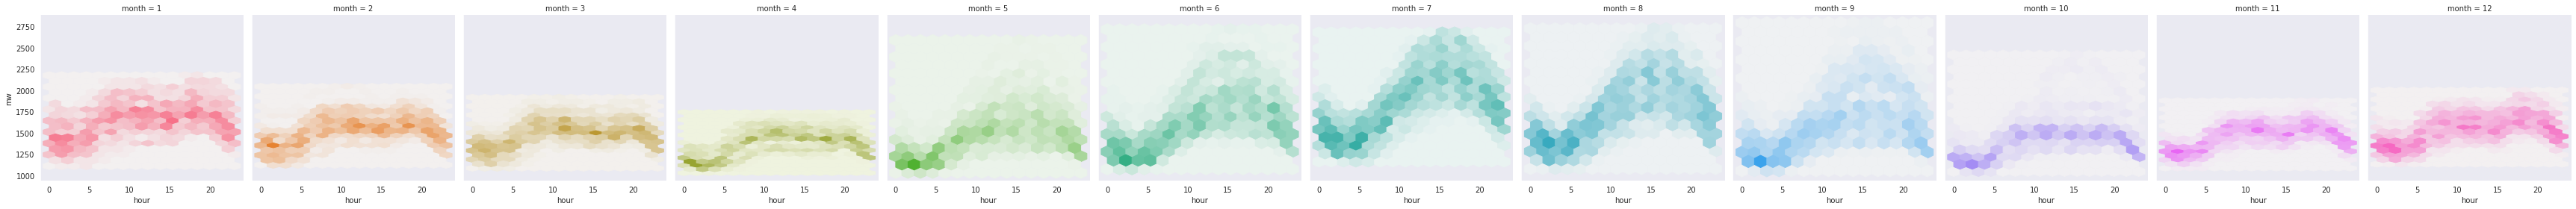

In [26]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)
    
with sns.axes_style('dark'):
    g = sns.FacetGrid(train, hue='month', col='month', height=4)
    g1 = sns.FacetGrid(train, hue='month', col='month', height=4)
    
g.map(hexbin, 'hour', 'temp')
g1.map(hexbin, 'hour', 'mw')

Let's look at monthly mean of temperature and energy consumption over time.

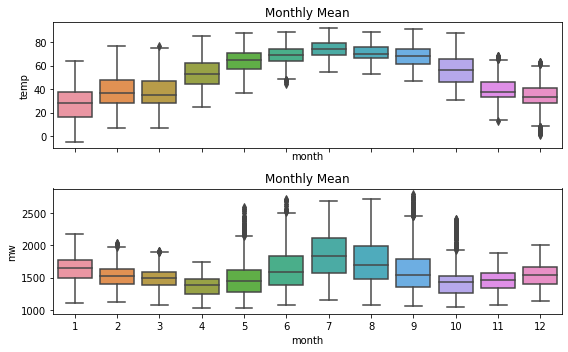

In [27]:
fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)

for name, ax in zip(['temp', 'mw'], axes):
    sns.boxplot(x='month', y=name, data=train, ax=ax)
    ax.set(title='Monthly Mean')
    
plt.tight_layout()

From above plots, Summer months tend to have larger variation in energy consumpton while to have the smallest variation in temperture. We can suspect that every 1 degree change in temperature during the Summer has larger impact on whether people will use air conditioning or not. Some occupants are more tolerant to heat based on preference, location, and desire to save energy, etc.

Let's break down the energy consumption to each month. It will show us which month has turning point where positive temp vs mw relationship turns into negative relationship and vise versa.

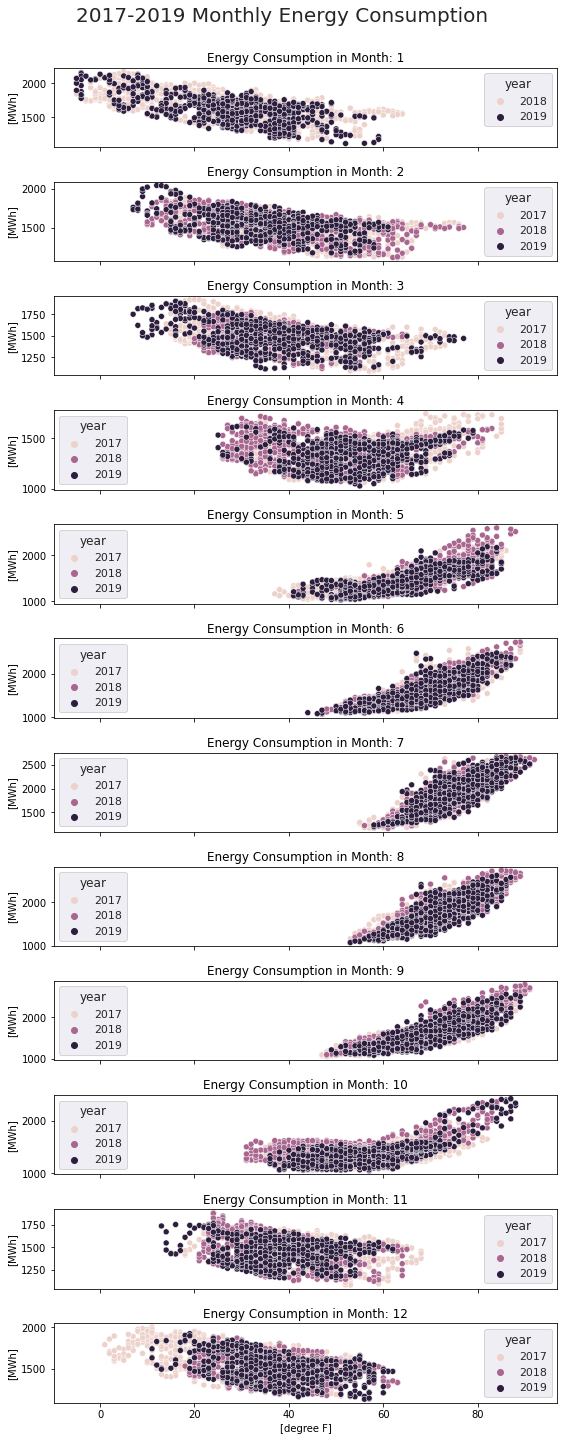

In [28]:
fig, axes = plt.subplots(12,1, figsize=(8,20), sharex=True)
sns.set(style='darkgrid')

for m, ax in zip(range(1,13), axes):
    plot = sns.scatterplot(data=train[train.month.isin([m])], x='temp', y='mw', hue='year', ax=ax)
    plot.set(title=f'Energy Consumption in Month: {m}', xlabel ='[degree F]',ylabel='[MWh]')
    #plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0., ncol=1)    

    fig.suptitle('2017-2019 Monthly Energy Consumption', fontsize=20, y=1.)
plt.tight_layout()

From above, we can see that **April & October** is the turning point of this positive/negative linear relationship between tmeparture and the energy consumption.

### 1.2 Seasonal Patterns

Let's look at the seasonal patterns:
* q1: Winter to Spring (January~April)
* q2: Spring to Summer (April~July)
* q3: Summer to Fall (July~October)
* q4: Fall to Winter (October~January)

In [29]:
train_q1 = train[train.month.isin([1,2,3,4])]
train_q2 = train[train.month.isin([4,5,6,7])]
train_q3 = train[train.month.isin([7,8,9,10])]
train_q4 = train[train.month.isin([10,11,12,1])]

#### 2017-2019 Q1-Q4 Correlation:

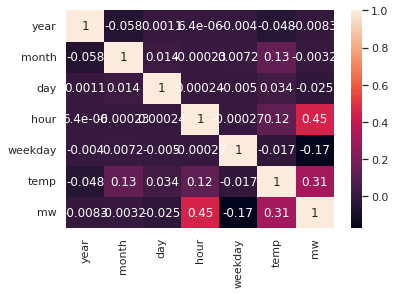

In [30]:
corr = train.corr(method='spearman')
sns.heatmap(corr, annot=True)
fig.show()

#### 2017-2019 Q1 Correlation:

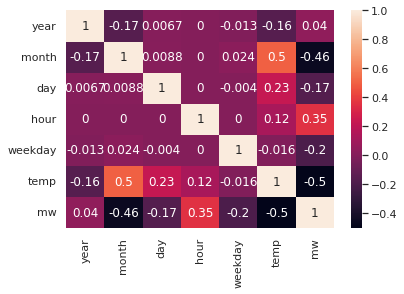

In [31]:
corr = train_q1.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 2017-2019 Q2 Correlation:

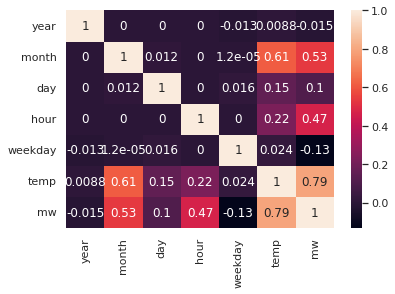

In [32]:
corr = train_q2.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 2017-2019 Q3 Correlation:

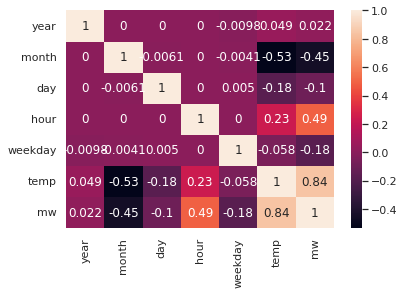

In [33]:
corr = train_q3.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 2017-2019 Q4 Correlation:

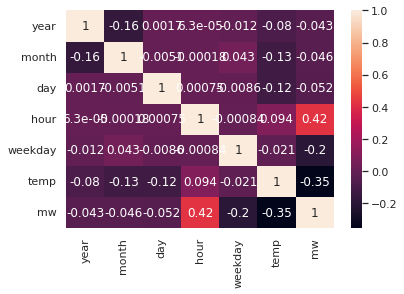

In [34]:
corr = train_q4.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

### Seasonal Correlation:

* **Summer** - Very high correlation with temp
* **Winter** - Medium correlation with temp. 
    * combination of temp/month/hour correlates with energy usage.


* train: hour(0.45) > temp(0.31) > weekday(-0.17)  
* q1: temp(-0.5) > month(-0.46) > hour(0.35)
* q2: temp(0.79) > month(0.53) > hour(0.47)
* q3: temp(0.84) > hour (0.49) > month(-0.45)
* q4: hour(0.42) > temp(-0.35) > weekday(0.2)

### Monthly Correlation:
* **March** is most **difficult** to predict with **temperature and hour of day**.
* **Summer** months are **easy** to predict with **temperature** alone.
* **January** is **not as easy** to predict with **temperature and hour of day**.


**temp [Month: 1,5,6,7,8,9]**
* May - temp(0.77) >> hour(0.49)
* Jun - temp(0.82) >> hour(0.53)
* Jul - temp(0.84) >> hour(0.6)
* Aug - temp(0.85) >> hour(0.56)
* Sep - temp(0.85) >> hour(0.48)
* Jan - temp(0.64) >> hour(0.38)


**temp & hour [Month: 2,3,10,12]**
* Feb - temp(-0.47) >= hour(0.4) > day(-0.36)
* Mar - temp(-0.38) >= hour(0.37)
* Oct - temp(0.56) >= hour(0.43)
* Dec - hour(0.5) >= temp(-0.44)


**Hour [Month: 4,11]**
* Apr - hour(0.49)
* Nov - hour(0.49) 

### 1.3 Weekday Patterns

#### 2017-2019 Energy Consumption per Weekday:

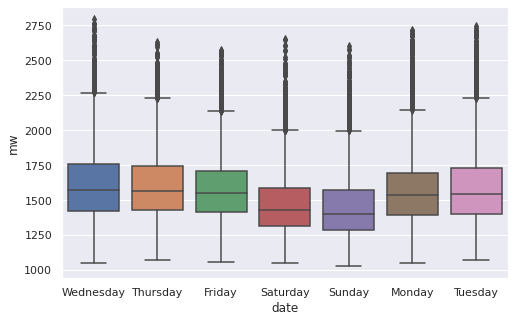

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(8,5), sharex=True)
sns.boxplot(data=train, x=train.index.day_name(), y='mw')
fig.show()

#### 2018 Energy Consumption in One-Week of January:

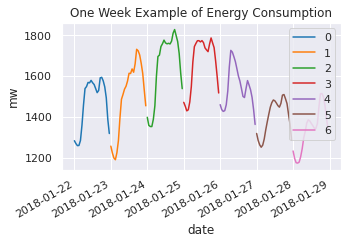

In [36]:
start, end = '2018-01-22', '2018-01-28'
one_week = train.loc[start:end]

fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.lineplot(data=one_week, x=one_week.index, y='mw', palette='tab10',hue='weekday')
fig.autofmt_xdate()
ax.legend(loc=1)
ax.set(title='One Week Example of Energy Consumption')
fig.show()

Depends on the day of week, energy consumption changes. There are double peaks in each day in most days of the week. It is likely ude to less energy usage around the lunch time when a lot of poeple are out of the building.

### 1.4 Hourly Patterns

#### 2018 July - Hourly Energy Consumption in One-Day:

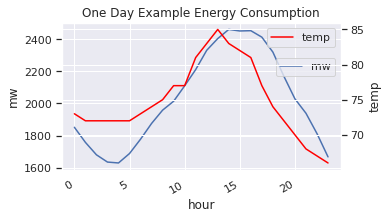

In [37]:
start, end = '2018-07-17', '2018-07-17'
one_day = train.loc[start:end]

fig, ax = plt.subplots(1,1, figsize=(5,3), sharex=True)
ax.set(title='One Day Example Energy Consumption')

g1 = sns.lineplot(data=one_day, x='hour', y='mw', label='mw')
ax2 = plt.twinx()
g2 = sns.lineplot(data=one_day, x='hour', y='temp', ax=ax2, color='red', label='temp')
sns.move_legend(g1, "upper right", bbox_to_anchor=(1., .8))
sns.move_legend(g2, "upper right", bbox_to_anchor=(1., 1))


fig.autofmt_xdate()


#### 2018 January - Hourly Energy Consumption in One-Week:

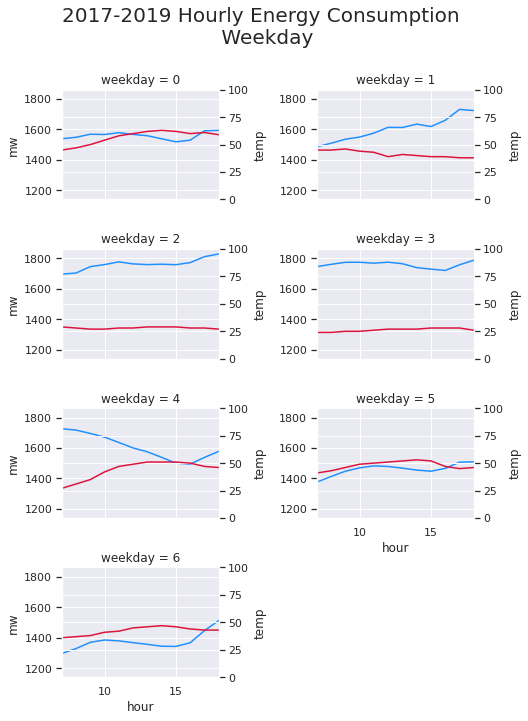

In [38]:
g = sns.relplot(data=one_week, x='hour', y='mw', col='weekday', col_wrap=2, kind='line', height=2.5, aspect=1.5, color='dodgerblue')

for weekday, ax in g.axes_dict.items():
    ax1 = ax.twinx()
    g1 = sns.lineplot(data=one_week[one_week['weekday'] == weekday], x='hour', y='temp', color='crimson', ax=ax1)
    g1.set(ylim=(0,100))
    g1.set(xlim=(7,18))
    
plt.suptitle('2017-2019 Hourly Energy Consumption \n Weekday', fontsize=20, y=1.)


g.tight_layout()
fig.show()

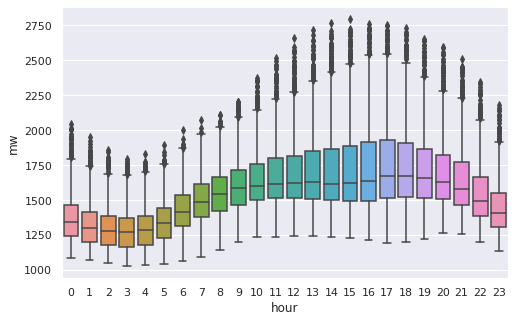

In [39]:
fig, axes = plt.subplots(1,1, figsize=(8,5), sharex=True)
sns.boxplot(data=train, x=train.hour, y='mw')
fig.show()

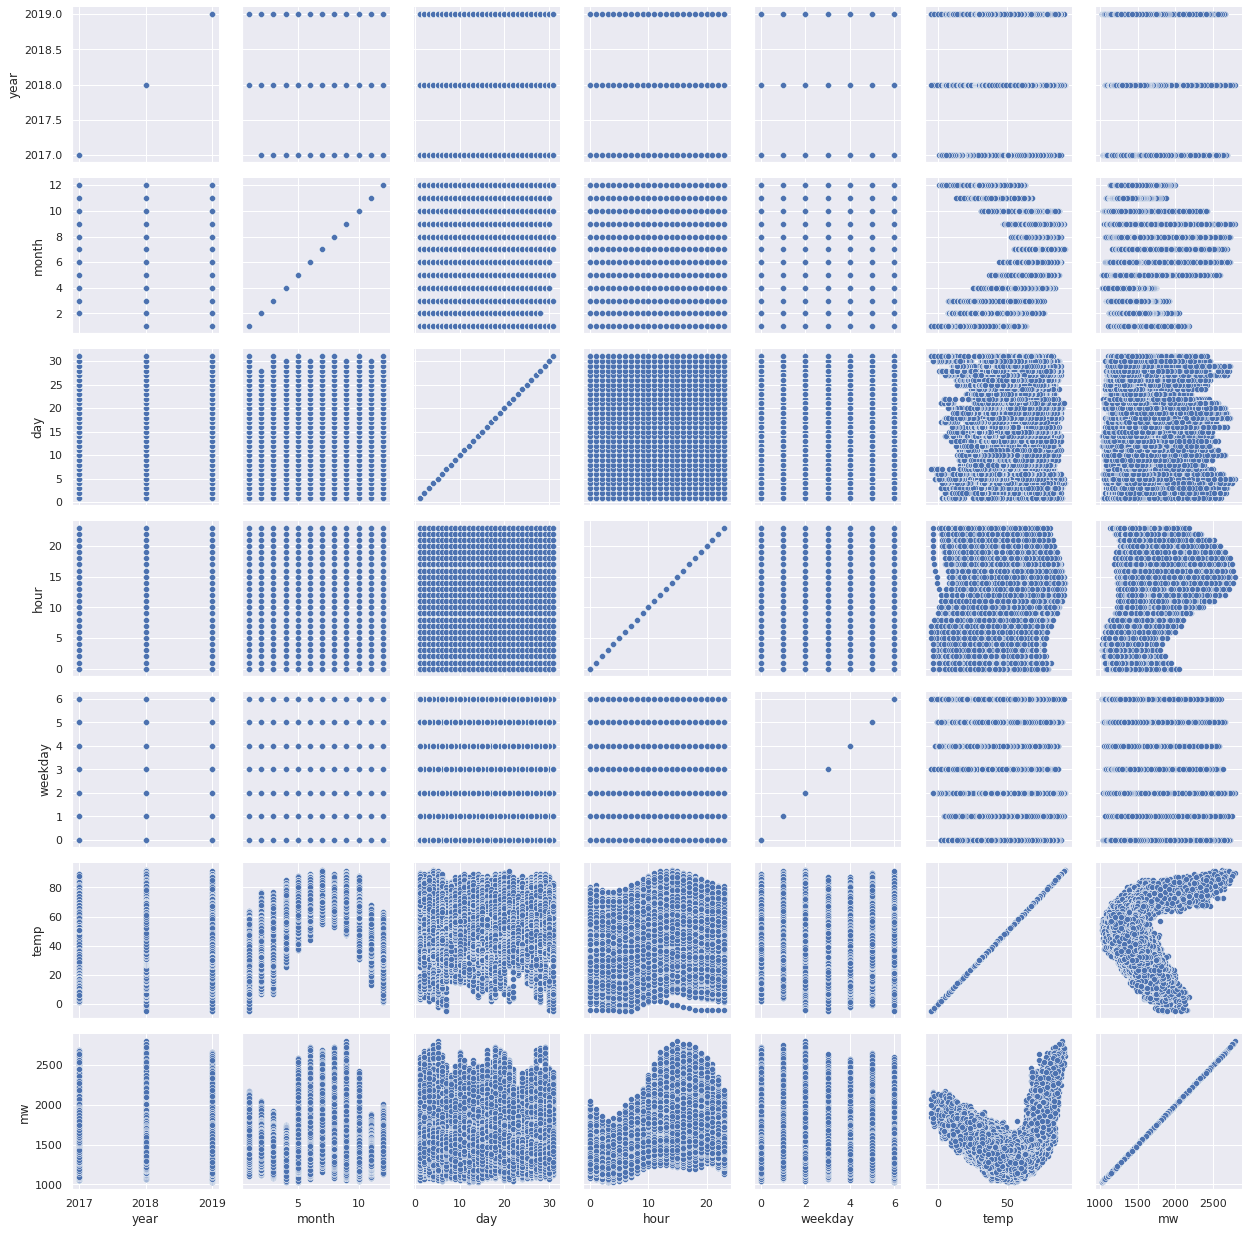

In [40]:
g = sns.PairGrid(train)
g.map(sns.scatterplot)

### 1.5 Resampling (Daily / Weekly / Monthly):

#### Lower resolution to Daily Mean:

In [41]:
train_daily_mean = train.resample('D').mean()
print(train_daily_mean.shape[0])
train_daily_mean.head(3)

1064


,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-01,2017.0,2.0,1.0,11.5,2.0,35.416667,1611.940083
2017-02-02,2017.0,2.0,2.0,11.5,3.0,30.375000,1623.083125
2017-02-03,2017.0,2.0,3.0,11.5,4.0,22.125000,1698.074250


#### Lower resolution to Weekly Mean:

In [42]:
train_weekly_mean = train.resample('W').mean()
print(train_weekly_mean.shape[0])
train_weekly_mean.head(3)

153


,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-05,2017.0,2.0,3.0,11.5,4.0,29.600000,1606.454000
2017-02-12,2017.0,2.0,9.0,11.5,3.0,39.607143,1531.264048
2017-02-19,2017.0,2.0,16.0,11.5,3.0,39.125000,1511.746649


#### Lower resolution to Monthly Mean:

In [43]:
# compute the monthly sums, setting the value to NaN for any month wich has 
# fewer than 28 days of data
train_monthly_mean = train.resample('M').mean()
print(train_monthly_mean.shape[0])
train_monthly_mean.head(3)

35


,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-28,2017.0,2.0,14.5,11.5,3.000000,41.363095,1505.044643
2017-03-31,2017.0,3.0,16.0,11.5,3.000000,40.377688,1490.788282
2017-04-30,2017.0,4.0,15.5,11.5,3.166667,57.861111,1363.225483


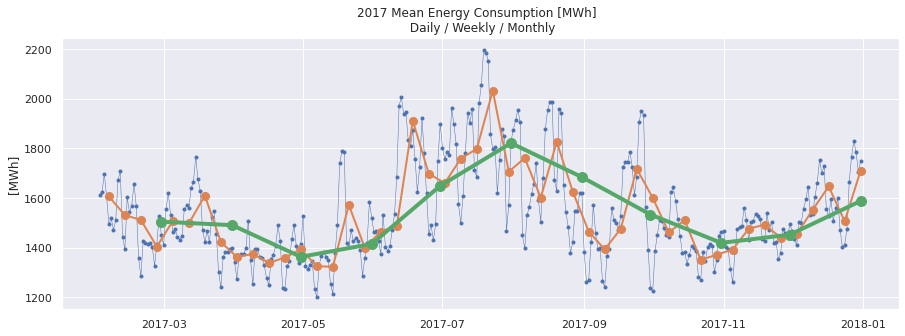

In [44]:
# start and end of the date range to extract
start, end = '2017-01', '2017-12'
# plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train_daily_mean.loc[start:end, 'mw'], marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(train_weekly_mean.loc[start:end, 'mw'], marker='o', linestyle='-', markersize=8, label='Weekly', linewidth=2)
ax.plot(train_monthly_mean.loc[start:end, 'mw'], marker='o', linestyle='-', markersize=10, label='Monthly', linewidth=4)
ax.set(title='2017 Mean Energy Consumption [MWh]  \n Daily / Weekly / Monthly', ylabel='[MWh]')

fig.show()


### 1.6 Rolling Average

#### Trends
Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean trends to smmoth a time series by averaging out variabtions at much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let's look at rolling means on those two time scales.

In [45]:
# the min_periods=360 argument accounts for a few isolated missing days
# in the mw time series
train_24h = train.rolling(window=24, center=True, min_periods=20).mean()
train_7d = train_24h.rolling(window=168, center=True, min_periods=160).mean()
train_30d = train_24h.rolling(window=720, center=True, min_periods=700).mean()
train_365d = train_24h.rolling(window=8760, center=True, min_periods=8700).mean()

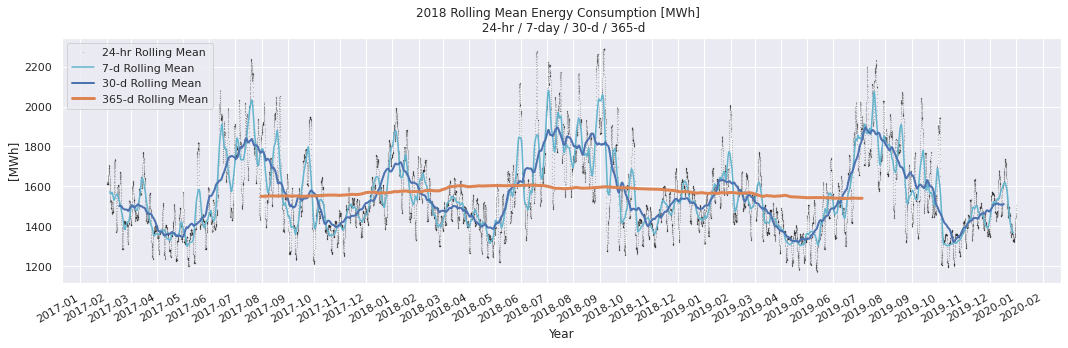

In [46]:
import matplotlib.dates as mdates

# plot 24-hr, 7-day rolling mean, and 30-day rolling mean time series
# start and end of the date range to extract
start, end = '2017-01', '2019-12'

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train_24h.loc[start:end, 'mw'], marker='.', markersize=0.2, color='0.2', linestyle='None', label='24-hr Rolling Mean')
ax.plot(train_7d.loc[start:end, 'mw'], linewidth=1.5, color='c',label='7-d Rolling Mean')
ax.plot(train_30d.loc[start:end, 'mw'], linewidth=2,label='30-d Rolling Mean')
ax.plot(train_365d.loc[start:end, 'mw'], linewidth=3, label='365-d Rolling Mean')

#set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Energy Consumption [MWh]')
ax.set_title('Trends in Energy Consumption')
ax.set(title='2018 Rolling Mean Energy Consumption [MWh]  \n 24-hr / 7-day / 30-d / 365-d', ylabel='[MWh]')

fig.autofmt_xdate()
fig.tight_layout()

We can see that the 7-day rolling mean has smoothed out all the weekly seasonality, while preserving the yearly seasonality.

## Project 2 Remarks:
* We observed seasonal trend of changing relationship between temperature and energy consumption.
* We looked at correlation between variables.
* We looked at variance of temperature (hourly/monthly).
* We looked at variance of energy consumption (hourly/monthly).
* We removed hourly/weekly/monthly/yearly noise using rolling mean.
* Now, we are ready to submit this assignment.